In [1]:
import numpy as np
import scipy.misc
import glob
import keras
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Dense, Dropout, Flatten
from keras.layers.merge import Concatenate
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from io import BytesIO
from IPython import display
from PIL import Image

def display_image(arr):
    b = BytesIO()
    Image.fromarray(np.uint8(arr)).save(b, format='png')
    data = b.getvalue()
    display.display(display.Image(data=data, format='png', embed=True))

labels = ['gyoku', 'ou', 'kin', 'gin', 'kei', 'kyo', 'kaku', 'hi', 'fu', 'narigin', 'narikei', 'narikyo', 'uma', 'ryu', 'to']
num_classes = len(labels) * 2 + 1

# input image dimensions
img_rows, img_cols = 64, 64
input_shape = (img_rows, img_cols, 1)

series_imgs = []
series_labels = []
for i, series in enumerate(sorted(glob.glob("../data/koma/*.npz"))):
    file = np.load(series)
    print(series)
    series_imgs.append(file['imgs'].astype(np.float32))
    series_labels.append(file['labels'])
num_series = len(series_imgs)

Using TensorFlow backend.


../data/koma/01.npz
../data/koma/02.npz
../data/koma/03.npz
../data/koma/04.npz
../data/koma/05.npz
../data/koma/06.npz
../data/koma/07.npz
../data/koma/08.npz
../data/koma/09.npz
../data/koma/10.npz
../data/koma/11.npz
../data/koma/12.npz
../data/koma/13.npz
../data/koma/14.npz
../data/koma/15.npz
../data/koma/16.npz
../data/koma/17.npz
../data/koma/18.npz
../data/koma/19.npz
../data/koma/20.npz
../data/koma/21.npz
../data/koma/22.npz
../data/koma/23.npz
../data/koma/24.npz
../data/koma/25.npz
../data/koma/26.npz
../data/koma/27.npz


In [2]:
# load all
x_all = np.empty((0, img_rows, img_cols))
y_all = np.empty((0, 2), np.int32)
for i in range(num_series):
    num_imgs = len(series_imgs[i])
    x_all = np.r_[x_all, series_imgs[i]]
    label_indices = []
    for j, label in enumerate(series_labels[i]):
        label_indices.append(labels.index(label))
    label_and_series = np.c_[label_indices, np.full((num_imgs), i)]
    y_all = np.r_[y_all, label_and_series]

# rot 180
x_all = np.r_[x_all, np.rot90(x_all, 2, (1, 2))]
y_rot = np.copy(y_all)
y_rot[:, 0] += len(labels)
y_all = np.r_[y_all, y_rot]

# space
space_imgs = np.load('../learn/space/space.npz')['imgs'].astype(np.float32)
x_all = np.r_[x_all, space_imgs]
y_space = np.full((len(space_imgs), 2), [len(labels) * 2, num_series])
y_all = np.r_[y_all, y_space]

print(x_all.shape)
print(y_all.shape)

# reshape to TF
x_all = x_all.reshape(x_all.shape[0], img_rows, img_cols, 1)
x_all = x_all.astype(np.float32)
x_all /= 255

(760, 64, 64)
(760, 2)


In [4]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.05)

# train_ids = np.where(y_all[:, 1] != 20)
# test_ids = np.where(y_all[:, 1] == 20)
# x_train = x_all[train_ids]
# x_test = x_all[test_ids]
# y_train = y_all[train_ids]
# y_test = y_all[test_ids]
# print(test_ids)
# display_image(np.uint8(x_test[0] * 255)[:, :, 0])

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train[:, 0], num_classes)
y_test = keras.utils.to_categorical(y_test[:, 0], num_classes)

In [5]:
datagen = ImageDataGenerator(rotation_range=15, zoom_range=0.25)
datagen.fit(x_train)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
__________

In [6]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=16), steps_per_epoch=x_train.shape[0],
                    epochs=80, verbose=1, validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/80
722/722 [==============================] - 12s - loss: 3.4137 - acc: 0.0367 - val_loss: 3.2081 - val_acc: 0.1316
Epoch 2/80
722/722 [==============================] - 10s - loss: 2.7905 - acc: 0.1454 - val_loss: 2.3009 - val_acc: 0.2368
Epoch 3/80
722/722 [==============================] - 10s - loss: 2.1942 - acc: 0.2745 - val_loss: 1.8328 - val_acc: 0.4211
Epoch 4/80
722/722 [==============================] - 10s - loss: 1.8364 - acc: 0.3715 - val_loss: 1.4315 - val_acc: 0.5789
Epoch 5/80
722/722 [==============================] - 10s - loss: 1.5310 - acc: 0.4745 - val_loss: 1.5181 - val_acc: 0.5789
Epoch 6/80
722/722 [==============================] - 10s - loss: 1.2807 - acc: 0.5492 - val_loss: 1.0455 - val_acc: 0.6053
Epoch 7/80
722/722 [==============================] - 10s - loss: 1.0845 - acc: 0.6184 - val_loss: 1.0110 - val_acc: 0.6053
Epoch 8/80
722/722 [==============================] - 10s - loss: 0.9034 - acc: 0.6813 - val_loss: 0.8776 - val_acc: 0.6579
Epoch 9/

In [7]:
pred_res = model.predict(x_test)
res = np.array([np.argmax(r) for r in pred_res])
ans = np.array([np.where(y == 1)[0][0] for y in y_test])
print(res)
print(ans)
correct = np.where(res == ans)[0]
errors = np.where(res != ans)[0]
print(errors)

[29 25 29  5 27 20 15  3 13 26 23 12 25 12 30 16 18  2  7  7 20 25  5 30 25
 22  7  1  7 27 11  1  6  6  0 29 17  9]
[29 25 29 13 27 20 15  3 13 26 23 12 25  8 30 15 18  2  7  7 20 26  5 30 25
 22  7  1  7 27 11  1  6  6  0 29 15  9]
[ 3 13 15 21 36]


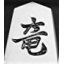

kyo


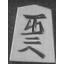

uma


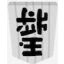

p
ou


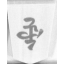

p
narikei


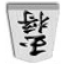

p
kin


In [8]:
for e in errors:
    display_image(np.uint8(x_test[e] * 255)[:, :, 0])
    if len(labels) > res[e]:
        print(labels[res[e]])
    else:
        print("p")
        print(labels[res[e] - len(labels)])

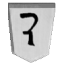

*to


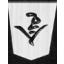

*narikei


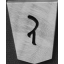

*to


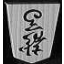

*uma


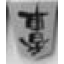

*kyo


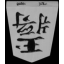

*gyoku


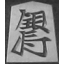

gin


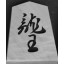

ryu


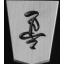

*narikyo


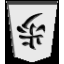

*fu


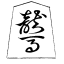

uma


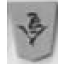

*narikei


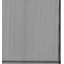

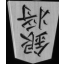

*gin


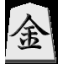

kin


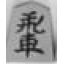

hi


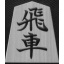

hi


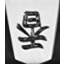

*kyo


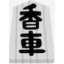

kyo


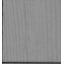

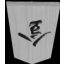

*narikei


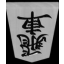

*hi


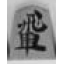

hi


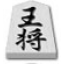

ou


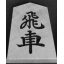

hi


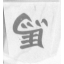

*uma


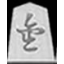

narikyo


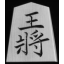

ou


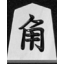

kaku


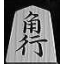

kaku


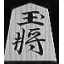

gyoku


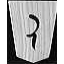

*to


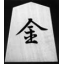

narigin


In [9]:
for e in correct:
    display_image(np.uint8(x_test[e] * 255)[:, :, 0])
    if len(labels) > res[e]:
        print(labels[res[e]])
    elif len(labels) * 2 > res[e]:
        print("*" + labels[res[e] - len(labels)])
    else:
        print("　")